# Question 3


---


Implement the backpropagation algorithm with support for the following optimisation functions

* sgd
* momentum based gradient descent
* nesterov accelerated gradient descent
* rmsprop
* adam
* nadam


### import data

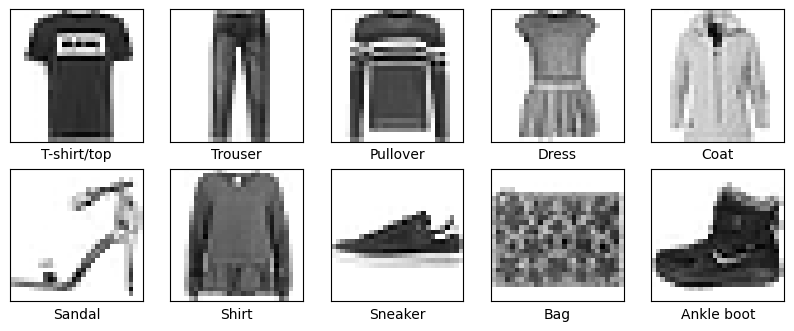

Done!
Size of Training data: (54000, 28, 28)
Size of Validation data: (6000, 28, 28)


In [2]:
import numpy as np
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt


"""""""""""""""""""""""""""""""""""""""""
Data and preprocesing
"""""""""""""""""""""""""""""""""""""""""
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Define class labels
class_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

class_num = 10

plt.figure(figsize=(10,10))
for i in range(class_num):

    idx = np.where(i == y_train)[0][0]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[idx], cmap=plt.cm.binary)
    plt.xlabel(class_labels[y_train[idx]])
plt.show()

def train_val_split(X, y, val_size, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    num_samples = X.shape[0]
    num_val_samples = int(num_samples * val_size)

    # Shuffle indices
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    # Split indices into train and test sets
    val_indices = indices[:num_val_samples]
    train_indices = indices[num_val_samples:]

    # Split data
    X_train, X_val = X[train_indices], X[val_indices]
    y_train, y_val = y[train_indices], y[val_indices]

    return X_train, X_val, y_train, y_val

x_train, x_val, y_train, y_val = train_val_split(x_train, y_train, val_size=0.1, random_state=2)
print("Done!")

print("Size of Training data:", x_train.shape)
print("Size of Validation data:", x_val.shape)

x_train_scaled = x_train/225.0
X_val_scaled = x_val/225
X_test_scaled = x_test/225

x_train_scaled = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1]*x_train_scaled.shape[2]).T
X_val_scaled = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1]*X_val_scaled.shape[2]).T
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1]*X_test_scaled.shape[2]).T

# One-hot encoding the labels
def one_hot_encode(labels, num_classes):
    num_samples = len(labels)
    one_hot_labels = np.zeros((num_classes, num_samples))
    for i, label in enumerate(labels):
        one_hot_labels[label, i] = 1
    return one_hot_labels

y_train_one_hot = one_hot_encode(y_train, class_num)
y_val_one_hot = one_hot_encode(y_val, class_num)
y_test_one_hot = one_hot_encode(y_test, class_num)

### Initialise weights

In [3]:
class InitialiseParams:
    def __init__(self, num_layers, hidden_size, input_features, num_classes):
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.input_features = input_features
        self.num_classes = num_classes

    def initialise_params(self):
        # Create a list of layer dimensions [input_features, hidden_size, ..., hidden_size, num_classes]
        layer_dim = [self.input_features]
        for _ in range(self.num_layers):
            layer_dim.append(self.hidden_size)
        layer_dim.append(self.num_classes)
        return layer_dim

    def random_ini(self, layer_dim):
        parameters = {}
        np.random.seed(0)
        num_layers = len(layer_dim)
        for l in range(1, num_layers):
            parameters[f'W{l}'] = np.random.randn(layer_dim[l], layer_dim[l-1]) * 0.01 # 0.1 doesn't work
            parameters[f'b{l}'] = np.zeros((layer_dim[l], 1))
        return parameters

    def xavier_ini(self, layer_dim):
        parameters = {}
        np.random.seed(0)
        num_layers = len(layer_dim)
        for l in range(1, num_layers):
            parameters[f'W{l}'] = np.random.randn(layer_dim[l], layer_dim[l-1]) * np.sqrt(1 / layer_dim[l-1])
            parameters[f'b{l}'] = np.zeros((layer_dim[l], 1))
        return parameters


### Activation functions

In [4]:
class Sigmoid():

    def __init__(self):
        pass

    def value(self, x):
      return 1/(1 + np.exp(-x))

    def grad(self, x):
      return self.value(x)*(1 - self.value(x))

class tanh():

    def __init__(self):
        pass

    def value(self, x):
      return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

    def grad(self, x):
      return 1 - self.value(x)**2

class identity():

    def __init__(self):
        pass

    def value(self, x):
      return x

    def grad(self, x):
      return 1

class ReLU():

    def __init__(self):
        pass

    def value(self, x):
      return np.maximum(0, x)

    def grad(self, x):
      return np.where(x > 0, 1, 0)

class softmax():

    def __init__(self):
        pass

    def value(self, x):
        x_stable = x - np.max(x, axis=0, keepdims=True)
        exp_values = np.exp(x_stable)
        softmax_values = exp_values / np.sum(exp_values, axis=0, keepdims=True)
        return softmax_values
    # def value(self, x):
    #   return np.exp(x) / np.sum(np.exp(x), axis=0)

    def grad(self, x):
      return self.value(x) * (1 - self.value(x))

### Forward propagation

In [5]:
class ForwardPropagation():
    def __init__(self):
        pass

    def forward_propagation(self, X, layer_dims, parameters, activation_fn):
        self.parameters = parameters
        self.activation_fn = activation_fn
        caches = []
        A = X
        L = len(layer_dims) - 1

        for l in range(1, L):
            A_prev = A
            W = self.parameters[f'W{l}']
            b = self.parameters[f'b{l}']
            Z = np.dot(W, A_prev) + b
            activation = self.activation_fn.value(Z)
            cache = (A_prev, W, b, Z, self.activation_fn)  # Include the activation function object in the cache
            caches.append(cache)
            A = activation

        # Output layer
        AL_prev = A
        WL = self.parameters[f'W{L}']
        bL = self.parameters[f'b{L}']
        ZL = np.dot(WL, AL_prev) + bL
        output = softmax().value(ZL)  # Using softmax activation for output layer

        cache = (AL_prev, WL, bL, ZL, softmax())  # Include softmax activation function in the cache
        caches.append(cache)

        return output, caches

### Backward Propagation

In [6]:
class BackPropagation:
    def __init__(self):
        pass

    @staticmethod
    def cross_entropy_loss(Y, Y_pred, parameters, alpha):
        m = Y.shape[1]
        cross_entropy_cost = -1/m * np.sum(Y * np.log(Y_pred + 1e-6))
        regularization_term = 0
        for key in parameters:
            if key.startswith('W'):
                regularization_term += np.sum(np.square(parameters[key]))
        l2_regularization_cost = (alpha / (2 * m)) * regularization_term
        return cross_entropy_cost + l2_regularization_cost

    @staticmethod
    def mean_squared_error_loss(Y, Y_pred, parameters, alpha):
        m = Y.shape[1]
        mse_cost = 1/(2*m) * np.sum((Y - Y_pred)**2)
        regularization_term = 0
        for key in parameters:
            if key.startswith('W'):
                regularization_term += np.sum(np.square(parameters[key]))
        l2_regularization_cost = (alpha / (2 * m)) * regularization_term
        return mse_cost + l2_regularization_cost

    def backward_propagation(self, Y, Y_pred, caches, loss_function, parameters, alpha):
        grads = {}
        m = Y.shape[1]
        L = len(caches)

        # Derivative of the loss function
        if loss_function == 'cross_entropy':
            dAL = - Y / (Y_pred + 1e-6)
        elif loss_function == 'mse':
            dAL = - (Y - Y_pred)

        # Output layer gradients
        current_cache = caches[L - 1]
        activation_fn = current_cache[-1].__class__.__name__  # Extract activation function class name from cache
        grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = self.linear_activation_backward(
            dAL, current_cache, activation_fn, parameters, alpha)

        # Hidden layers gradients
        for l in reversed(range(L - 1)):
            current_cache = caches[l]
            activation_fn = current_cache[-1].__class__.__name__  # Extract activation function class name from cache
            dA_prev_temp, dW_temp, db_temp = self.linear_activation_backward(
                grads["dA" + str(l + 2)], current_cache, activation_fn, parameters, alpha)
            grads["dA" + str(l + 1)] = dA_prev_temp
            grads["dW" + str(l + 1)] = dW_temp
            grads["db" + str(l + 1)] = db_temp

        return grads

    @staticmethod
    def linear_activation_backward(dA, cache, activation_fn, parameters, alpha):
        A_prev, W, b, Z = cache[:-1]  # Extract all but the last element from cache

        if activation_fn == Sigmoid().__class__.__name__:
            activation = Sigmoid()
            dZ = dA * activation.grad(Z)
        elif activation_fn == tanh().__class__.__name__:
            activation = tanh()
            dZ = dA * activation.grad(Z)
        elif activation_fn == ReLU().__class__.__name__:
            activation = ReLU()
            dZ = dA * activation.grad(Z)
        elif activation_fn == softmax().__class__.__name__:
            activation = softmax()
            dZ = dA * activation.grad(Z)
        else:
            raise ValueError("Unsupported activation function")

        m = A_prev.shape[1]
        dW = 1/m * np.dot(dZ, A_prev.T) + (alpha / m) * W  # Added L2 regularization term
        db = 1/m * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)

        return dA_prev, dW, db

### Optimiser

In [7]:
class Optimiser:
    def __init__(self):
        pass

    def stochastic_gradient_descent(self, parameters, grads, learning_rate, alpha):
        updated_parameters = parameters.copy()

        for param_name in parameters.keys():
            grad_key = 'd' + param_name

            # Update parameters with L2 regularization
            updated_parameters[param_name] -= learning_rate * (grads[grad_key] + alpha * parameters[param_name])

        return updated_parameters


    def momentum(self, parameters, grads, velocities, beta, learning_rate, alpha):
        updated_parameters = parameters.copy()

        for param_name in parameters.keys():
            grad_key = 'd' + param_name

            # Update velocities
            velocities[param_name] = beta * velocities[param_name] + learning_rate * (grads[grad_key] + alpha * parameters[param_name])

            # Update parameters using velocities
            updated_parameters[param_name] -= velocities[param_name]

        return updated_parameters


    def nestrov(self, X_batch, y_batch, parameters, velocities, beta, learning_rate, loss_function, activation_fn, alpha, layer_dims):
        updated_parameters = parameters.copy()  # Make a copy of the original parameters
        future_parameters = {}

        for param_name in parameters.keys():
            grad_key = 'd' + param_name
            # Update velocities based on gradients evaluated at the approximate future position
            future_parameters[param_name] = parameters[param_name] - beta * velocities[param_name]

        forward_propagator = ForwardPropagation()
        backpropagator = BackPropagation()

        # Forward propagation
        AL, caches = forward_propagator.forward_propagation(X_batch, layer_dims, future_parameters, activation_fn)
        # Backward propagation
        grads = backpropagator.backward_propagation(y_batch, AL, caches, loss_function, parameters, alpha)

        for param_name in parameters.keys():
            grad_key = 'd' + param_name
            future_grads = grads[grad_key]  # Gradients evaluated at the approximate future position
            velocities[param_name] = beta * velocities[param_name] + learning_rate * (future_grads + alpha * parameters[param_name])
            # Update parameters using updated velocities
            updated_parameters[param_name] -= velocities[param_name]

        return updated_parameters


    def rmsprop(self, parameters, grads, velocities, beta, learning_rate, alpha, epsilon):
        updated_parameters = parameters.copy()

        for param_name in parameters.keys():
            grad_key = 'd' + param_name

            # Update velocities
            velocities[param_name] = beta * velocities[param_name] + (1 - beta) * np.square(grads[grad_key] + alpha * parameters[param_name])

            # Update parameters using updated velocities
            updated_parameters[param_name] -= (learning_rate/np.sqrt(velocities[param_name] + epsilon)) * (grads[grad_key] + alpha * parameters[param_name])

        return updated_parameters


    def adam(self, parameters, grads, moment, velocities, beta1, beta2, learning_rate, alpha, epsilon):
        updated_parameters = parameters.copy()
        moment_hat = {}
        velocities_hat = {}

        for param_name in parameters.keys():
            grad_key = 'd' + param_name

            # Update moment
            moment[param_name] = beta1 * moment[param_name] + (1 - beta1) * (grads[grad_key] + alpha * parameters[param_name])

            moment_hat[param_name] = moment[param_name] / (1 - beta1)

            # Update velocities
            velocities[param_name] = beta2 * velocities[param_name] + (1 - beta2) * (grads[grad_key] + alpha * parameters[param_name])**2

            velocities_hat[param_name] = velocities[param_name] / (1 - beta2)

            # Update parameters using updated velocities
            updated_parameters[param_name] -= (learning_rate / (np.sqrt(velocities_hat[param_name]) + epsilon)) * moment_hat[param_name]

        return updated_parameters



    def nadam(self, parameters, grads, moment, velocities, beta1, beta2, learning_rate, alpha, epsilon):
        updated_parameters = parameters.copy()
        moment_hat = {}
        velocities_hat = {}

        for param_name in parameters.keys():
            grad_key = 'd' + param_name

            # Update moment
            moment[param_name] = beta1 * moment[param_name] + (1 - beta1) * grads[grad_key]

            # Update velocities
            velocities[param_name] = beta2 * velocities[param_name] + (1 - beta2) * grads[grad_key]**2

            # Bias correction
            moment_hat[param_name] = moment[param_name] / (1 - beta1)
            velocities_hat[param_name] = velocities[param_name] / (1 - beta2)

            # Update parameters using Nesterov Adam update rule
            updated_parameters[param_name] -= (learning_rate / (np.sqrt(velocities_hat[param_name]) + epsilon)) * (
                        beta1 * moment_hat[param_name] + ((1 - beta1) * grads[grad_key]) / (1 - beta1))

        return updated_parameters

### train file

In [13]:
import numpy as np

def train(X_train, x_val, y_train, y_val, parameters_random, activation_fn, layer_dims, forward_propagator, backpropagator, optimiser, optimizer_type, loss_function, max_epoch, batch_size, learning_rate, beta, beta1, beta2, alpha):
    num_samples = X_train.shape[1]
    num_batches = num_samples // batch_size

    # Get initial parameters from forward propagator
    parameters = parameters_random

    # Initialize velocities and moment
    velocities = {param_name: np.zeros_like(param) for param_name, param in parameters.items()}
    moment = {param_name: np.zeros_like(param) for param_name, param in parameters.items()} # for adam

    for epoch in range(max_epoch):
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size

            X_batch = X_train[:, start_idx:end_idx]
            y_batch = y_train[:, start_idx:end_idx]

            # Forward propagation
            AL, caches = forward_propagator.forward_propagation(X_batch, layer_dims, parameters, activation_fn)

            # Compute loss
            if loss_function == 'cross_entropy':
                cost = backpropagator.cross_entropy_loss(y_batch, AL, parameters, alpha)
            elif loss_function == 'mse':
                cost = backpropagator.mean_squared_error_loss(y_batch, AL, parameters, alpha)
            else:
                raise ValueError("Unsupported loss function")

            # Backward propagation
            grads = backpropagator.backward_propagation(y_batch, AL, caches, loss_function, parameters, alpha)

            # Update parameters using the specified optimizer
            if optimizer_type == 'sgd':
                parameters = optimiser.stochastic_gradient_descent(parameters, grads, learning_rate, alpha)
            elif optimizer_type == 'momentum':
                parameters = optimiser.momentum(parameters, grads, velocities, beta, learning_rate, alpha)
            elif optimizer_type == 'nestrov':
                parameters = optimiser.nestrov(X_batch, y_batch, parameters, velocities, beta, learning_rate, loss_function, activation_fn, alpha)
            elif optimizer_type == 'rmsprop':
                parameters = optimiser.rmsprop(parameters, grads, velocities, beta, learning_rate, alpha)
            elif optimizer_type == 'adam':
                parameters = optimiser.adam(parameters, grads, moment, velocities, beta1, beta2, learning_rate, alpha)
            elif optimizer_type == 'nadam':
                parameters = optimiser.nadam(parameters, grads, moment, velocities, beta1, beta2, learning_rate, alpha, epsilon=1e-6)
            else:
                raise ValueError("Unsupported optimizer type")

            # validation
            AL_val, caches_val = forward_propagator.forward_propagation(x_val, layer_dims, parameters, activation_fn)

            # Compute loss
            if loss_function == 'cross_entropy':
                cost_val = backpropagator.cross_entropy_loss(y_val, AL_val, parameters, alpha)
            elif loss_function == 'mse':
                cost_val = backpropagator.mean_squared_error_loss(y_val, AL_val, parameters, alpha)
            else:
                raise ValueError("Unsupported loss function")

            if batch_idx % batch_size == 0:
                print(f"Epoch {epoch+1}/{max_epoch}, Batch {batch_idx+1}/{num_batches}, Loss: {cost}, validation: {cost_val}")

    return parameters

### main file

In [18]:
"""""""""""""""""""""""""""""""""""""""""
Define the model
"""""""""""""""""""""""""""""""""""""""""
# Configuration dictionary for user inputs
config = {
    'num_layers': 3,
    'hidden_size': 65,
    'input_features': 28 * 28,
    'num_classes': 10,
    'optimizer_type': 'nadam',
    'learning_rate': 0.001,
    'beta': 0.9,
    'beta1': 0.9,
    'beta2': 0.999,
    'max_epoch': 5,
    'batch_size': 34,
    'loss_function': 'cross_entropy',
    'initialisation_type': 'xavier',
    'alpha': 0.005
}

# Initialise parameters
initializer = InitialiseParams(config['num_layers'], config['hidden_size'], config['input_features'], config['num_classes'])
layer_dims = initializer.initialise_params()
if config['initialisation_type'] == 'random':
    parameters_random = initializer.random_ini(layer_dims)
elif config['initialisation_type'] == 'xavier':
    parameters_random = initializer.xavier_ini(layer_dims)
else:
    raise ValueError("Invalid initialization type. Choose 'random' or 'xavier'.")

# Activation function
activation_fn = tanh()

# Create forward and backward propagators
forward_propagator = ForwardPropagation()
backpropagator = BackPropagation()

# Compute gradients using backward propagation
AL, caches = forward_propagator.forward_propagation(x_train_scaled, layer_dims, parameters_random, activation_fn)
grads = backpropagator.backward_propagation(y_train_one_hot, AL, caches, config['loss_function'], parameters_random, alpha=config['alpha'])

# Choose optimizer type and parameters
optimizer_type = config['optimizer_type']
learning_rate = config['learning_rate']
beta = config['beta']
beta1 = config['beta1']
beta2 = config['beta2']
optimiser = Optimiser()

# Train the model
print("Training starts : ")
parameters_trained = train(x_train_scaled, X_val_scaled, y_train_one_hot, y_val_one_hot, parameters_random,
                           activation_fn, layer_dims, forward_propagator, backpropagator, optimiser, optimizer_type,
                           loss_function=config['loss_function'], max_epoch=config['max_epoch'], batch_size=config['batch_size'],
                           learning_rate=learning_rate, beta=beta, beta1=beta1, beta2=beta2, alpha=config['alpha'])

print("Training end")
print("")
print("")


"""""""""""""""""""""""""""""""""""""""""
Test the model
"""""""""""""""""""""""""""""""""""""""""

def predict(X_test, parameters_trained, forward_propagator, layer_dims, activation_fn):
    AL, _ = forward_propagator.forward_propagation(X_test, layer_dims, parameters_trained, activation_fn)
    predictions = np.argmax(AL, axis=0)
    return predictions

def calculate_accuracy(predictions, y_test):
    correct_predictions = np.sum(predictions == y_test)
    total_predictions = len(y_test.T)
    accuracy = (correct_predictions / total_predictions) * 100
    return accuracy


# Test
predictions = predict(X_test_scaled, parameters_trained, forward_propagator, layer_dims, activation_fn)
accuracy = calculate_accuracy(predictions, y_test)
print("Prediction accuracy:", accuracy)

Training starts : 
Epoch 1/5, Batch 1/1588, Loss: 2.3534852788778884, validation: 2.2742247282448327
Epoch 1/5, Batch 35/1588, Loss: 1.8066818646420917, validation: 1.5324220131882735
Epoch 1/5, Batch 69/1588, Loss: 1.20805698911943, validation: 1.2994366095533274
Epoch 1/5, Batch 103/1588, Loss: 1.2840157170692301, validation: 1.212210044925763
Epoch 1/5, Batch 137/1588, Loss: 1.4928031118982634, validation: 1.173633852675791
Epoch 1/5, Batch 171/1588, Loss: 1.805531185598529, validation: 1.2309385053678235
Epoch 1/5, Batch 205/1588, Loss: 1.0978504498787545, validation: 1.1656514410849708
Epoch 1/5, Batch 239/1588, Loss: 1.1313946796051588, validation: 1.1481209775700558
Epoch 1/5, Batch 273/1588, Loss: 1.0073450282725853, validation: 1.085666693719702
Epoch 1/5, Batch 307/1588, Loss: 0.9072291589825309, validation: 1.0944157032839341
Epoch 1/5, Batch 341/1588, Loss: 1.1225106365250608, validation: 1.1712055186952688
Epoch 1/5, Batch 375/1588, Loss: 1.074156467149627, validation: 1.0